#**Head Side Prediciton**

#**Description**
Goal is to predict the patient's head side in the depth images. We employ CNN-based approach for it. 

You can run notebook cell-by-cell (shift+ENTER shortcut) or run all cells together from the Runtime menu.

#**Initial Setup**

##**Folder Structure**

Before you began, create a shortcut of shared folder in your google drive and make sure your drive folder structure looks like this.
```
***Drive Structure***
|-- My Drive
  |-- 스키아 공유폴더 (the shared folder)
    |-- deep_learning
      |-- Image Projects
        |-- Head Direction
          |-- Implementation
          |-- dataset
          |-- models
          |-- scripts
      |-- PCD Projects
```
[Shared folder link](https://drive.google.com/drive/folders/1UfdnM8wgcZYc18fMgzd9tyrYPISM63WL?usp=sharing)

NOTE: 

- If you are running code on the shared drive, then try to make a separate copy of this notebook for your usage. This is just to keep the original version safe.

- Trained models will be stored inside the `models` folder. Try to create the model fodler with your name so that you can keep your models separate from otehr people. You can do that in the `Training` section.


##**Mount drive and import modules**

Run the next cell, open the link, Sign in, copy the code and paste in the box and ENTER.

In [ ]:
# Mount the drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# Change current working directory
import os
os.chdir(r'/content/gdrive/MyDrive/Projects/head_location')
os.getcwd()

'/content/gdrive/MyDrive/Projects/head_location'

In [ ]:
# Add folder with .py files (utility scripts) to system path
import sys
sys.path.append(r'/contect/gdrive/MyDrive/Projects/head_location/scripts')

In [ ]:
import os
import cv2
import time
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.metrics import confusion_matrix

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import RandomSampler

import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder

from matplotlib import pyplot as plt
from scripts import dataloader_new
from scripts.dataloader_new import *

#**Dataset Preparation**

##**Exploring dataset**

In [ ]:
# Set dataset paths
TRAIN_DIR = './dataset_extended/train/'
TEST_DIR = './dataset_extended/test/'

# Check hardware accelerator
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# Exploring Dataset

classes = os.listdir(TRAIN_DIR)
print("Total Classes: ",len(classes))

# Counting total train, & test images

train_count = 0
test_count = 0

for _class in classes:
    train_count += len(os.listdir(TRAIN_DIR + _class))
    test_count += len(os.listdir(TEST_DIR + _class))

print("Total train images: ",train_count)
print("Total test images: ",test_count)

Total Classes:  4
Total train images:  7330
Total test images:  34


##**Helper Functions**

In [ ]:
# Utility to apply transforms
def get_transform():
  mean = 127.5
  std = 127.5
  normalize = T.Normalize(mean=mean, std=std)
  return T.Compose([normalize])

##**Loading Classification Dataset**

In [ ]:
# Load dataset using custom dataset class (defined in scripts folder)
train_dataset = CustomDataset(TRAIN_DIR, transforms=get_transform())
test_dataset = CustomDataset(TEST_DIR, transforms=get_transform())

print(len(train_dataset))
print(len(test_dataset))

7330
34


In [ ]:
# Check shape of one training example
print(train_dataset[0][0].shape)

torch.Size([3, 240, 320])


Here image height is 240, width is 320 and number of channels is 3.

In [ ]:
# Check pixel values of training example (should be between -1 and 1 after normalization)
print(train_dataset[0][0])

tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]],

        [[-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         ...,
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.],
         [-1., -1., -1.,  ..., -1., -1., -1.]]])


Amount of data is very small. Data from only three patients is used for testing purpose. Training data is increase from only around 75 images to 1650 images via augmentation. The augmentation notebook is also provided inside scripts fodler if you are interested in taking a look at it.

Data is separated for testing on subject-level and not image-level to have unbiased evaluation of the model.

In [ ]:
train_data_loader = DataLoader(dataset = train_dataset, batch_size = 16, shuffle=True)
test_data_loader = DataLoader(dataset = test_dataset, batch_size = 16, shuffle=False)

In [ ]:
# Check length of  dataloader (1650 divided by 16)
print(len(train_data_loader))

459


In [ ]:
# Shape of one dataloader instance
for i, (images, labels) in enumerate(train_data_loader):
  print(images.shape)
  break

torch.Size([16, 3, 240, 320])


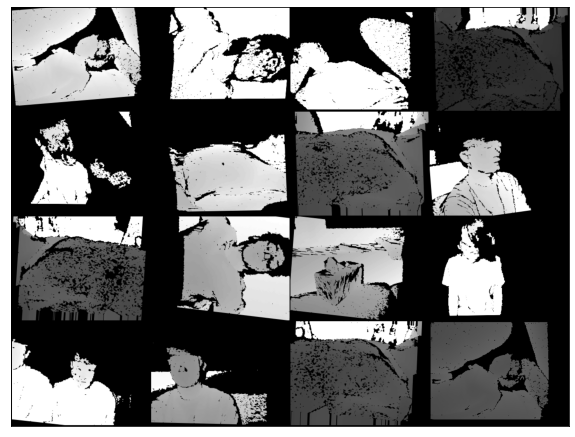

In [ ]:
# Visualize one training batch
for images, labels in train_data_loader:
    fig, ax = plt.subplots(figsize = (10, 10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, 4, normalize=True).permute(1,2,0), cmap='gray')
    break

#**Load Onnx model**

In [ ]:
!pip install onnx

     |████████████████████████████████| 12.3 MB 181 kB/s 


In [17]:
# Create a folder on your drive to saved trained models
# Try creating a fodler with your name
name = 'new_dataset'

try:
    os.makedirs(os.path.join(os.getcwd(), f'models_{name}'))
except FileExistsError:
    print("Directory already exists!")
    pass

modelDir = os.path.join(os.getcwd(), f'models_{name}')

Directory already exists!


In [ ]:
import onnx

# Load the ONNX model
model = onnx.load(os.path.join(modelDir, 'best_model.onnx'))

In [ ]:
# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
onnx.helper.printable_graph(model.graph)

'graph torch-jit-export (\n  %X[FLOAT, 1x3x240x320]\n) initializers (\n  %fc.weight[FLOAT, 4x512]\n  %fc.bias[FLOAT, 4]\n  %193[FLOAT, 64x3x7x7]\n  %194[FLOAT, 64]\n  %196[FLOAT, 64x64x3x3]\n  %197[FLOAT, 64]\n  %199[FLOAT, 64x64x3x3]\n  %200[FLOAT, 64]\n  %202[FLOAT, 64x64x3x3]\n  %203[FLOAT, 64]\n  %205[FLOAT, 64x64x3x3]\n  %206[FLOAT, 64]\n  %208[FLOAT, 128x64x3x3]\n  %209[FLOAT, 128]\n  %211[FLOAT, 128x128x3x3]\n  %212[FLOAT, 128]\n  %214[FLOAT, 128x64x1x1]\n  %215[FLOAT, 128]\n  %217[FLOAT, 128x128x3x3]\n  %218[FLOAT, 128]\n  %220[FLOAT, 128x128x3x3]\n  %221[FLOAT, 128]\n  %223[FLOAT, 256x128x3x3]\n  %224[FLOAT, 256]\n  %226[FLOAT, 256x256x3x3]\n  %227[FLOAT, 256]\n  %229[FLOAT, 256x128x1x1]\n  %230[FLOAT, 256]\n  %232[FLOAT, 256x256x3x3]\n  %233[FLOAT, 256]\n  %235[FLOAT, 256x256x3x3]\n  %236[FLOAT, 256]\n  %238[FLOAT, 512x256x3x3]\n  %239[FLOAT, 512]\n  %241[FLOAT, 512x512x3x3]\n  %242[FLOAT, 512]\n  %244[FLOAT, 512x256x1x1]\n  %245[FLOAT, 512]\n  %247[FLOAT, 512x512x3x3]\n  %24

#**Testing (Inference)**

In [ ]:
!pip install onnxruntime

     |████████████████████████████████| 4.5 MB 29.8 MB/s 


In [ ]:
# Define labels
classes = ['head_left', 'head_right', 'none', 'standing']

In [ ]:
import onnxruntime

ort_session = onnxruntime.InferenceSession(os.path.join(modelDir, 'best_model.onnx'))

In [ ]:
def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

In [16]:
img = cv2.imread("./dataset_extended/test_prediction/head_right_6.png", 1)
img = torch.from_numpy(img)
img = img.permute(2, 0, 1)    
img = img.unsqueeze(0)
img = img.float()
img = get_transform()(img)
print(img.dtype)

torch.float32


In [ ]:
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img)}
ort_outs = ort_session.run(None, ort_inputs)

In [ ]:
print(ort_outs)

[array([[-6.0863266,  9.24609  , -2.7269762, -4.9118032]], dtype=float32)]


In [ ]:
prediction = np.argmax(ort_outs)
predicted_class = classes[prediction]
print(predicted_class)

head_right


In [ ]:
from PIL import Image

# Define labels
classes = ['head_left', 'head_right', 'none', 'standing']

In [ ]:
# Define prediction function

def classify(model, image_transforms, images_path, classes):
  model = model.eval()
  for image in os.listdir(images_path):
    label = os.path.splitext(image)[0]

    img = cv2.imread(os.path.join(images_path, image), 1)
    img = torch.from_numpy(img)
    img = img.permute(2, 0, 1)    
    img = img.unsqueeze(0)
    img = img.float()
    img = image_transforms(img)

    output = model(img)
    print(output)
    _, prediction = torch.max(output.data, 1)

    predicted_class = classes[prediction.item()]

    img = img.permute(0,2,3,1)
    img = img.numpy()
    plt.imshow((img[0] * 255).astype(np.uint8), cmap='gray')
    plt.title(f'Prediction: {predicted_class}, Actual: {label}')
    plt.show()

tensor([[ 6.6819,  0.3917, -4.4896, -8.0970]], grad_fn=<AddmmBackward>)


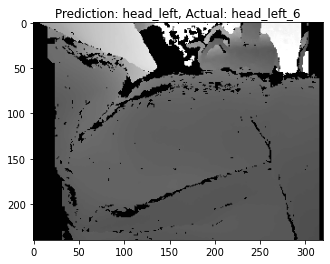

tensor([[ 4.4894,  2.1550, -4.1860, -7.6221]], grad_fn=<AddmmBackward>)


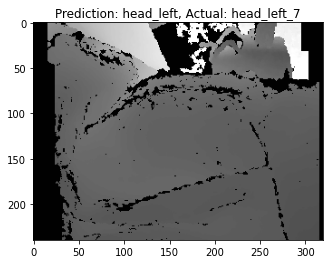

tensor([[ 5.6075,  0.9909, -4.4330, -7.4583]], grad_fn=<AddmmBackward>)


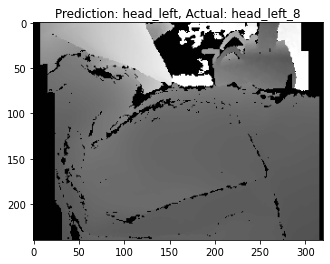

tensor([[ 6.9747,  0.3889, -5.6723, -7.2045]], grad_fn=<AddmmBackward>)


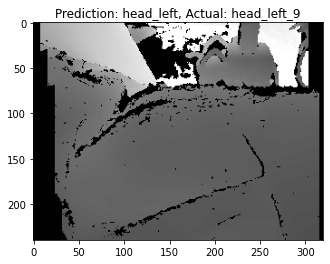

tensor([[ 4.9491,  0.6418, -3.9881, -6.4053]], grad_fn=<AddmmBackward>)


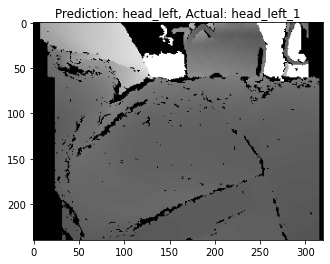

tensor([[ 5.0443,  2.5321, -5.5983, -7.0543]], grad_fn=<AddmmBackward>)


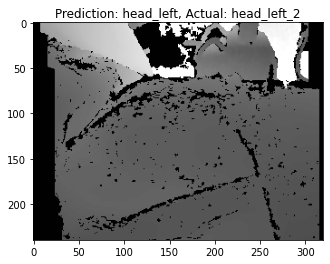

tensor([[ 6.7104,  1.8793, -5.9700, -8.3710]], grad_fn=<AddmmBackward>)


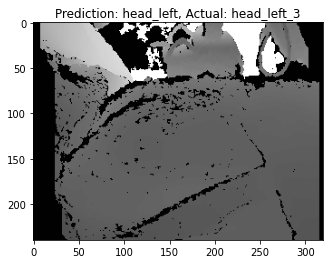

tensor([[-2.1822,  6.3474, -2.6025, -5.3840]], grad_fn=<AddmmBackward>)


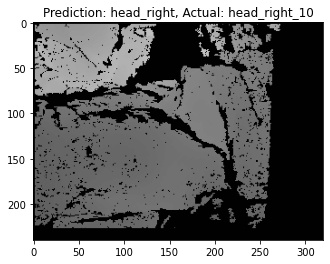

tensor([[-3.6842,  8.2403, -3.2834, -5.3988]], grad_fn=<AddmmBackward>)


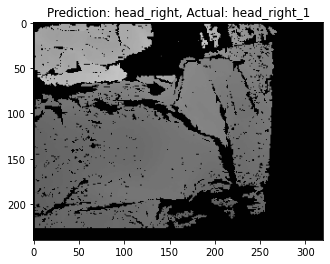

tensor([[-2.2493,  5.9237, -3.0944, -4.1410]], grad_fn=<AddmmBackward>)


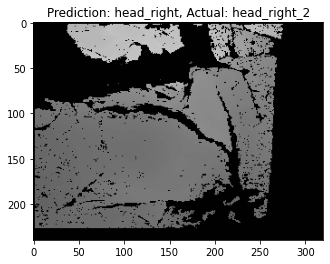

tensor([[-2.2685,  6.6199, -3.5685, -4.7747]], grad_fn=<AddmmBackward>)


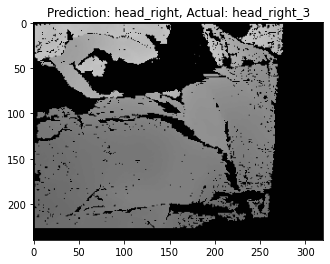

tensor([[-1.5163,  7.5701, -5.0416, -5.1537]], grad_fn=<AddmmBackward>)


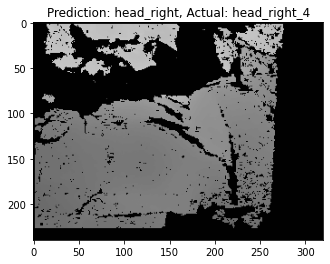

tensor([[-2.8996,  6.5454, -2.4779, -4.6924]], grad_fn=<AddmmBackward>)


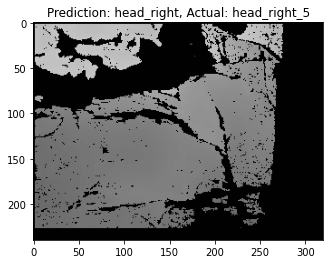

tensor([[ 4.5972,  0.0125, -1.5920, -7.9508]], grad_fn=<AddmmBackward>)


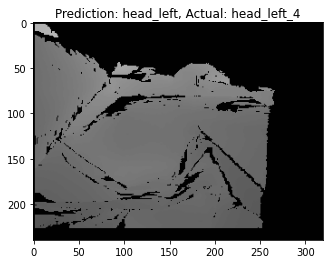

tensor([[ 3.8244,  1.1650, -1.4556, -8.2574]], grad_fn=<AddmmBackward>)


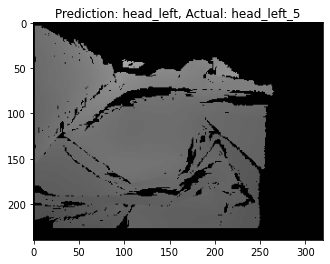

tensor([[-6.6596, -2.0311,  8.7989, -2.7273]], grad_fn=<AddmmBackward>)


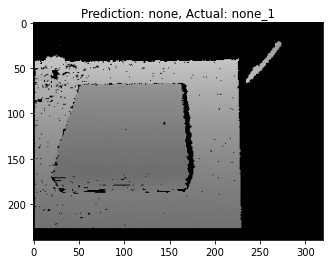

tensor([[-4.5964, -2.1791,  7.7874, -3.8040]], grad_fn=<AddmmBackward>)


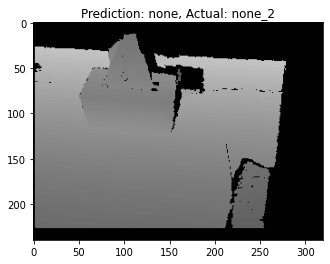

tensor([[ 5.3616, -2.9104, -2.2190, -4.7060]], grad_fn=<AddmmBackward>)


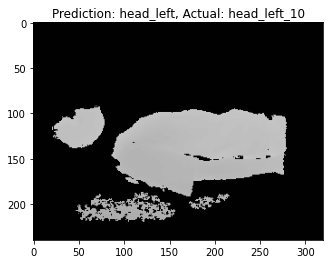

tensor([[-6.0863,  9.2461, -2.7270, -4.9118]], grad_fn=<AddmmBackward>)


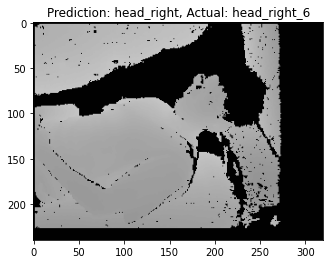

tensor([[ 8.8219, -4.6876, -6.0214, -3.9329]], grad_fn=<AddmmBackward>)


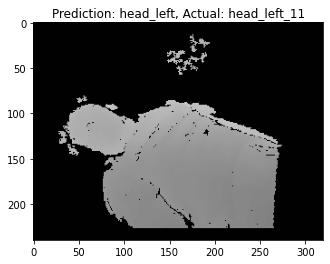

tensor([[-3.0140,  7.0298, -1.6393, -6.5129]], grad_fn=<AddmmBackward>)


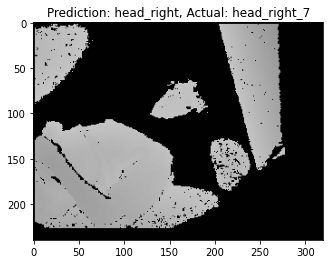

tensor([[-3.9258,  8.4873, -4.1419, -5.0199]], grad_fn=<AddmmBackward>)


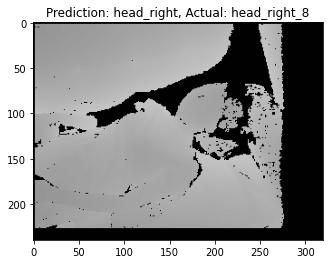

tensor([[-2.4848,  8.1970, -2.5242, -7.5041]], grad_fn=<AddmmBackward>)


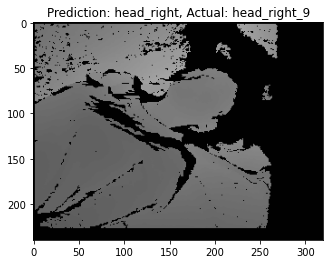

tensor([[-5.3072, -4.0940, -1.6095,  7.7231]], grad_fn=<AddmmBackward>)


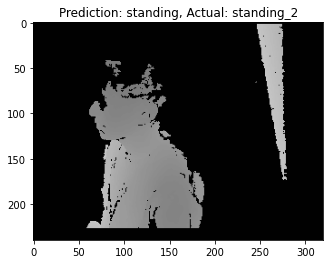

tensor([[-3.7072, -4.3974, -2.2296,  6.9636]], grad_fn=<AddmmBackward>)


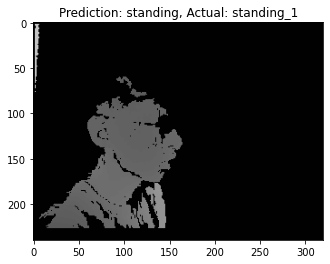

tensor([[-5.5029, -1.6692, -0.7397,  4.3855]], grad_fn=<AddmmBackward>)


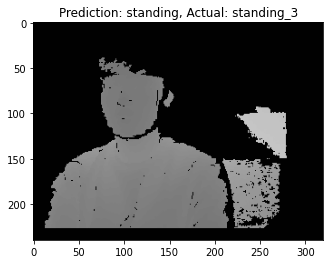

tensor([[-6.1806, -1.8207,  9.9493, -5.2349]], grad_fn=<AddmmBackward>)


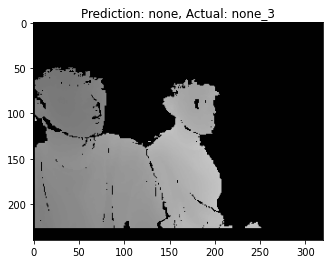

tensor([[-4.7511, -4.4497, -3.0090,  8.5233]], grad_fn=<AddmmBackward>)


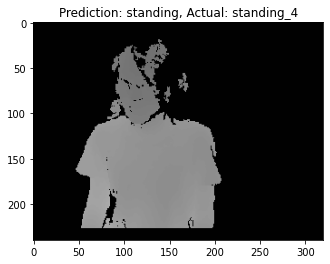

tensor([[-4.4037, -3.6656, -3.6494,  8.0498]], grad_fn=<AddmmBackward>)


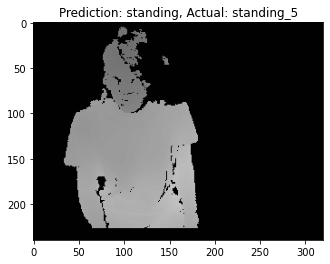

tensor([[-2.3482, -2.1342,  5.8830, -4.1462]], grad_fn=<AddmmBackward>)


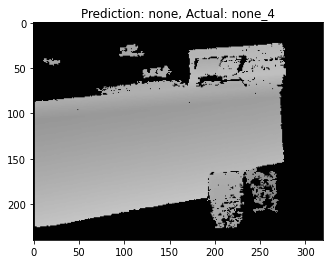

tensor([[ 5.1677, -2.1413, -0.8667, -6.2250]], grad_fn=<AddmmBackward>)


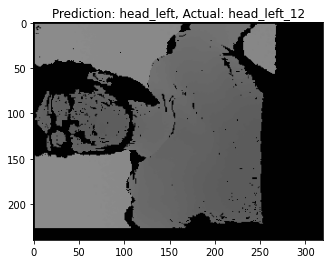

tensor([[ 7.4030, -2.0796, -3.6000, -7.0223]], grad_fn=<AddmmBackward>)


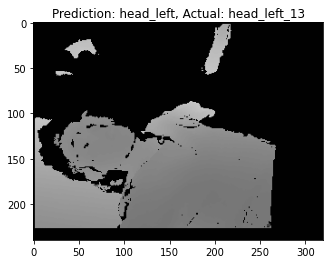

tensor([[ 6.6980, -5.6011, -0.4179, -5.6902]], grad_fn=<AddmmBackward>)


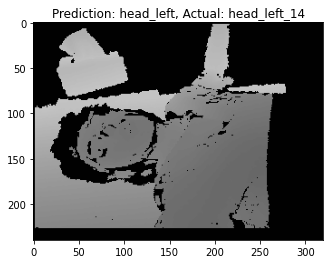

tensor([[-5.6462, -3.3288,  8.8771, -2.0551]], grad_fn=<AddmmBackward>)


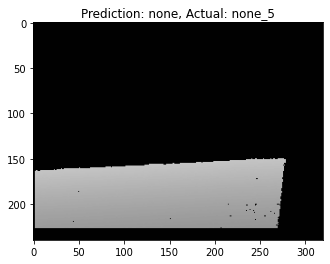

In [ ]:
# Predict on test data
classify(model, get_transform(), './dataset_extended/test_prediction', classes)

##**Better visualization for predicitons**

In [ ]:
def classify_fancy(model, image_transforms, images_path, classes):
  model = model.eval()
  offset = 30
  for image in os.listdir(images_path):
    img = cv2.imread(os.path.join(images_path, image), 1)
    dimension = img.shape
    height = dimension[1] 
    width = dimension[0] 

    img = torch.from_numpy(img)
    img = img.permute(2, 0, 1)    
    img = img.unsqueeze(0)
    img = img.float()
    img = image_transforms(img)

    output = model(img)
    _, prediction = torch.max(output.data, 1)

    predicted_class = classes[prediction.item()]

    img = img.permute(0,2,3,1)
    img = img.numpy()

    if (predicted_class == 'head_left'):
      x = width / 2 + offset
      y = height / 3 + offset - 10

      plt.arrow(x, y, -75, 0, width = 10)
      plt.imshow((img[0] * 255).astype(np.uint8), cmap='gray')
      plt.title(f'Prediction: {predicted_class}')
      plt.show()

    elif (predicted_class == 'head_right'):
      x = width / 2 + offset
      y = height / 3 + offset - 10

      plt.arrow(x, y, 75, 0, width = 10)
      plt.imshow((img[0] * 255).astype(np.uint8), cmap='gray')
      plt.title(f'Prediction: {predicted_class}')
      plt.show()

    elif (predicted_class == 'standing'):
      x = width / 2 + offset
      y = height / 3 + offset - 10

      plt.arrow(x, y, 0, -75, width = 10)
      plt.imshow((img[0] * 255).astype(np.uint8), cmap='gray')
      plt.title(f'Prediction: {predicted_class}')
      plt.show()

    else:
      plt.imshow((img[0] * 255).astype(np.uint8), cmap='gray')
      plt.title(f'Prediction: {predicted_class}')
      plt.show()

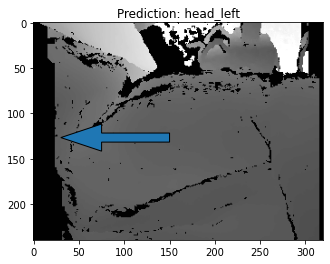

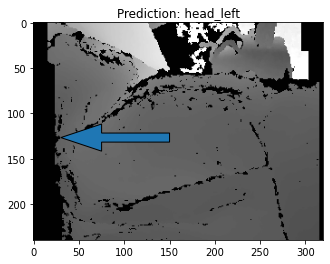

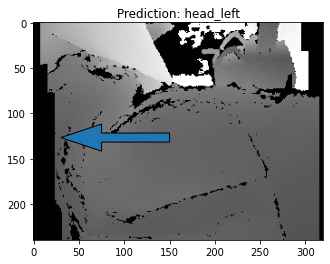

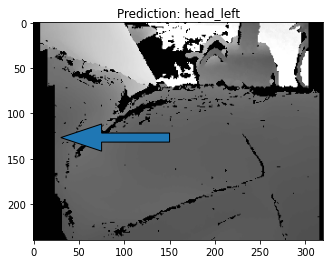

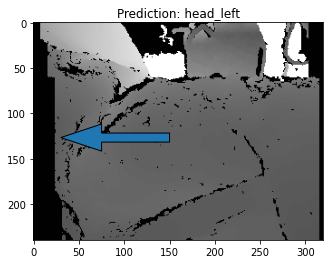

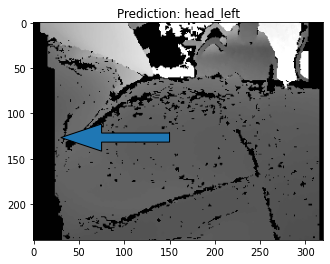

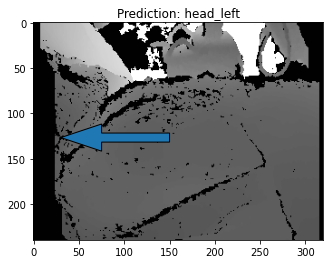

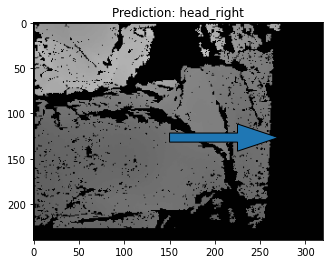

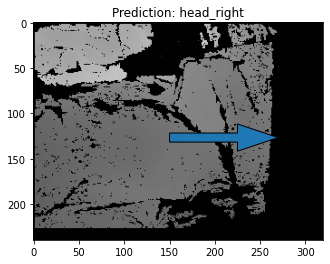

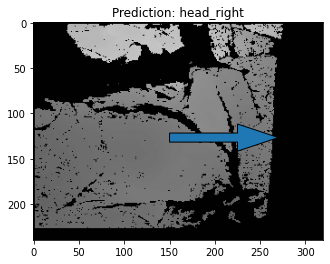

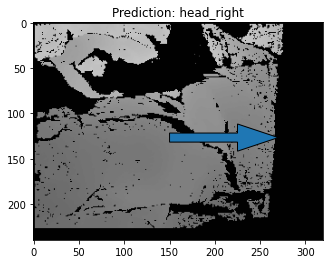

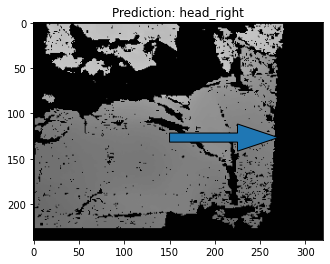

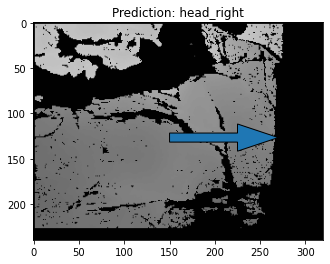

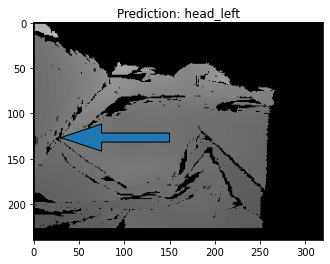

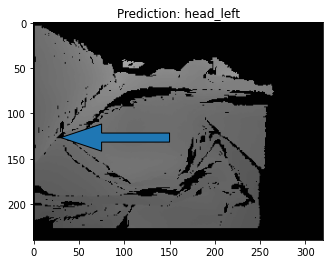

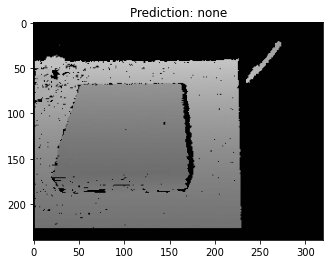

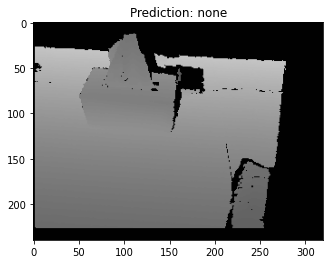

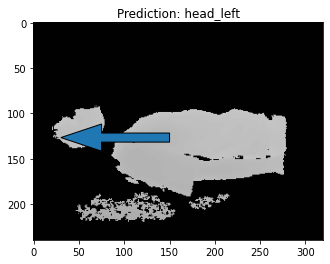

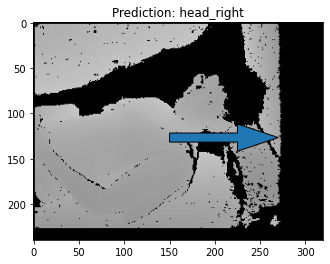

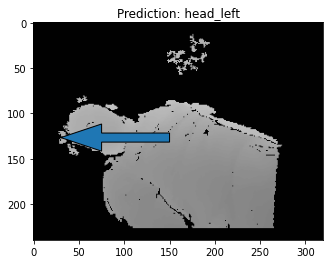

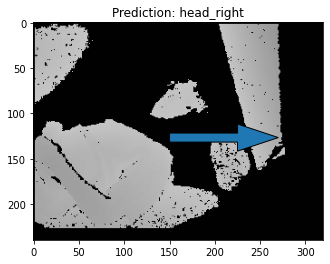

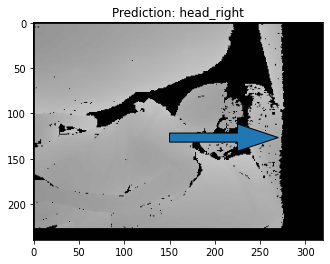

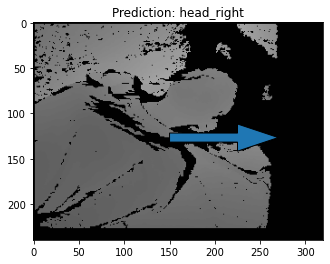

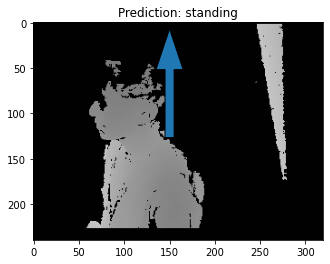

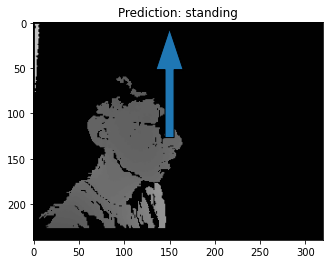

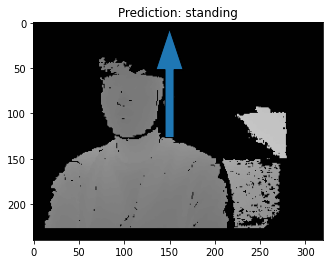

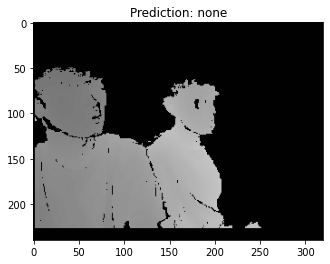

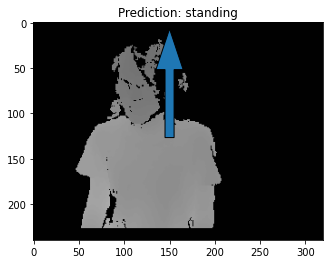

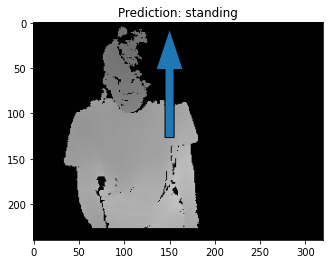

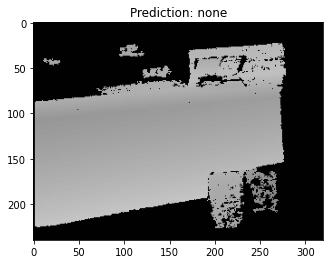

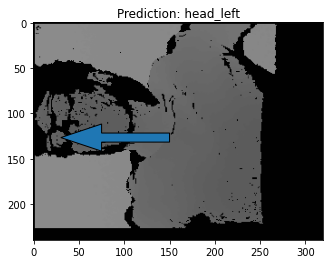

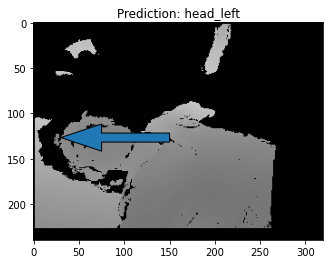

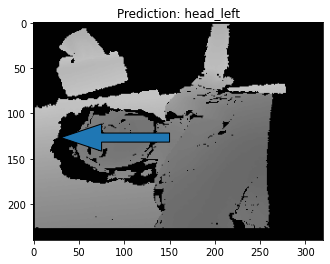

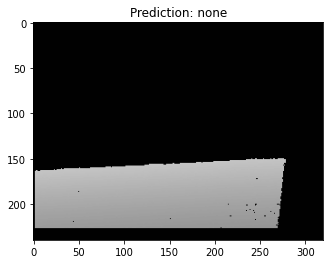

In [ ]:
classify_fancy(model, get_transform(), './dataset_extended/test_prediction', classes)

#**Exporting model to other formats**

##**Convert to Onnx (for Unity and other platforms)**

In [ ]:
input = torch.randn(1, 3, 240, 320)
torch.onnx.export(model, 
                  input, 
                  os.path.join(modelDir, 'best_model.onnx'), 
                  export_params=True,
                  opset_version=11,
                  do_constant_folding=True,
                  input_names = ['X'], 
                  output_names = ['Y']
                  )

##**Convert to CoreML model (for iOS)**

In [ ]:
input = torch.randn(1, 3, 240, 320)
traced_model = torch.jit.trace(model, input)

In [ ]:
# Install coreML library
!pip install coremltools==5.0b3

     |████████████████████████████████| 1.5 MB 30.5 MB/s 


In [ ]:
import coremltools as ct

In [ ]:
# Convert to Core ML using the Unified Conversion API
model = ct.convert(
    traced_model,
    inputs=[ct.ImageType(name="input_1", shape=input.shape)])

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 192/192 [00:01<00:00, 115.06 ops/s]


In [ ]:
# Save model
model.save(os.path.join(modelDir, "best_model.mlmodel"))